## Sampling and resampling

The "Nyquist-Shannon sampling theorem" (https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem;
Shannon 1949) lays out the theoretical foundation for recording continuous signal (like visual images)
as discrete samples (like pixels).

Key elements are the "sampling theorem" (aka "Nyquist sampling"):

"""
If a function `x(t)` contains no frequencies higher than `B` hertz, it is completely determined by
giving discrete samples at a series of points spaced 1/(2B) seconds apart.
"""

Once we have discrete samples, a "reconstruction" formula allows us to reproduce the original continuous signal.
Theoretically, this involves treating the discrete samples as a train of weighted delta functions,
which we then low-pass filter to remove high-frequency aliases ("anti-aliasing").  The ideal low-pass filter
is a top-hat in frequency (Fourier) space (low frequencies pass through unaltered; high frequencies are zeroed out).  In real space, the top-hat is a `sinc` function.  So a reconstruction formula for `x(t)` given samples
`x_i` is:

$x(t) = \sum_{i=-\infty}^{+\infty} x_i \, \textrm{sinc}\left(\frac{t - i T}{T}\right)$

where $T$ is the time between samples.

This also allows us to *shift* the original signal by evaluating the reconstruction function at points
other than the discrete samples.

Since the `sinc` has infinite support, in practice we
use approximations to `sinc` that have "compact support".  A very common choice in audio and image processing
are the "Lanczos" kernels (Lanczos 1956), which are like the `sinc` function but go to zero outside a window.
The Lanczos-n filter is

$L_n(t) = n \frac{sin(\pi t) sin(\pi t / n)}{\pi^2 t^2}$

(and $1$ at $t=0$, and $0$ outside the range $\pm n$).

A very common choice for $n$ is $3$ (Lanczos-3).

In [198]:
# For the astronomy application we're going to do below, we'll need these new packages.

In [354]:
] add WCS FITSIO

 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]


In [355]:
using Images
using Plots
using TestImages

In [357]:
function lanczos3(x)
    if x < -3 || x > +3
        0.
    elseif x == 0
        1.
    else
        3. * sin(pi * x) * sin(pi * x / 3) / (pi^2 * x^2)
    end
end

lanczos3 (generic function with 1 method)

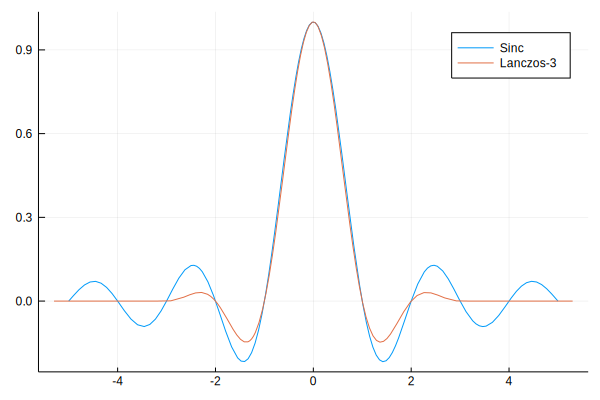

In [358]:
plot(sinc, label="Sinc")
plot!(lanczos3, label="Lanczos-3")

In [372]:
function lanczos3_shift(samples, sx)
    # "sx": float, index in "samples" to interpolate
    cx = round(Int, sx)
    conv = 0.
    wt = 0.
    for x = cx-3 : cx+3
        weight = lanczos3(x - sx)
        wt += weight
        if x < 1 || x > length(samples)
            continue
        end
        conv += samples[x] * weight
    end
    conv / wt
end

lanczos3_shift (generic function with 1 method)

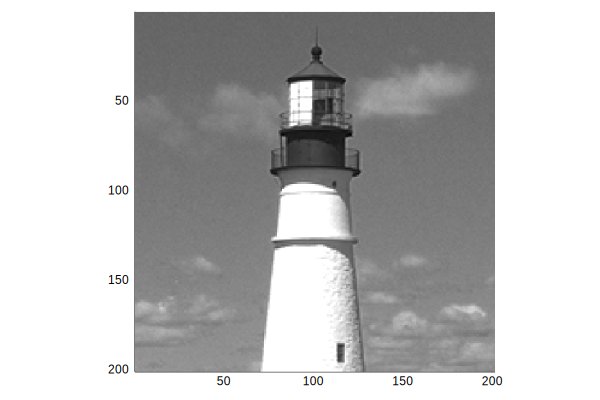

In [361]:
img = testimage("lighthouse")
red = Float32.(channelview(img))[1, 50:250, 250:450]
plot(Gray.(red))

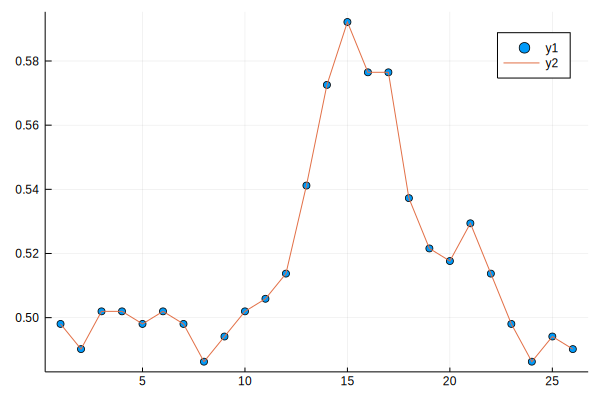

In [364]:
samples = red[125:150, 150]
plot(samples, seriestype=:scatter)
plot!(samples)

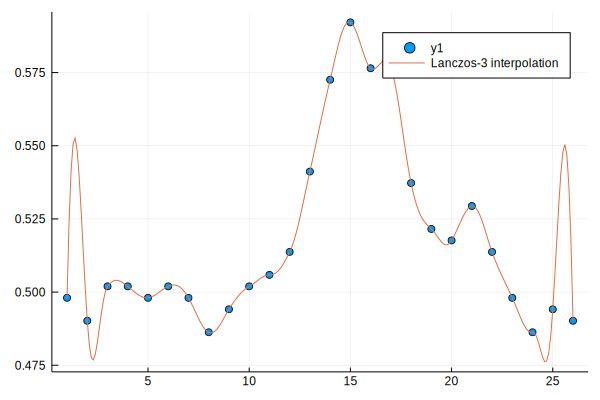

In [373]:
plot(samples, seriestype=:scatter)
xx = 1:0.1:length(samples)
s = [lanczos3_shift(samples, x) for x in xx]
plot!(xx, s, label="Lanczos-3 interpolation")

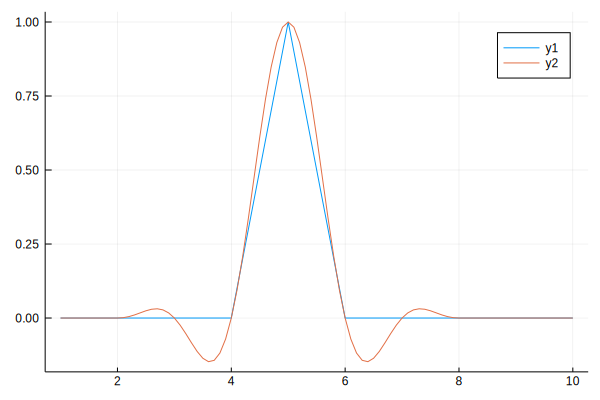

In [376]:
samples2 = [0, 0,0,0,1,0,0,0,0,0]
#samples2 = ones(10)
plot(samples2)
xx = 1:0.1:length(samples2)
s = [lanczos3_shift(samples2, x) for x in xx]
plot!(xx, s)

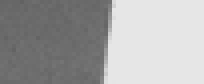

In [377]:
Gray.(red[140:160, 50:100] .- 0.1)

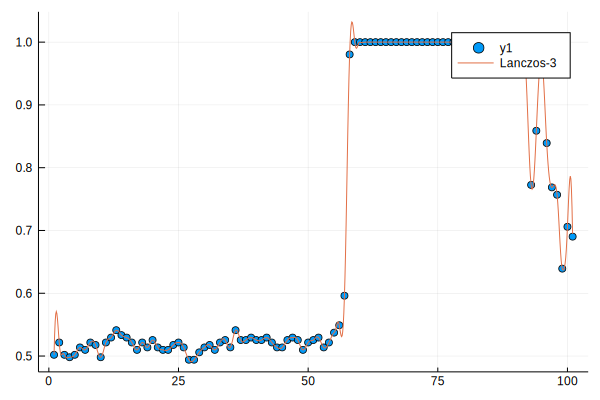

In [383]:
samples2 = red[150, 20:120]
plot(samples2, seriestype=:scatter)
xx = 1:0.11:length(samples2)
s = [lanczos3_shift(samples2, x) for x in xx]
plot!(xx, s, label="Lanczos-3")

In [384]:
Gray.(samples2 .- 0.1)

In [386]:
Gray.(s .- 0.1)

In [387]:
function lanczos3_shift_2d(samples, sx, sy)
    H,W = size(samples)
    shifted_row = []
    cy = round(Int, sy)
    for y = cy-3 : cy+3
        if y < 1 || y > H
            sh = 0.
        else
            sh = lanczos3_shift(samples[y, :], sx)
        end
        append!(shifted_row, sh)
    end
    lanczos3_shift(shifted_row, sy - (cy - 3))
end

lanczos3_shift_2d (generic function with 1 method)

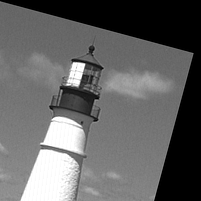

In [390]:
angle = 15.
rangle = deg2rad(angle);
H,W = size(red)
resampled = zeros((H,W))
for y = 1:H
    for x = 1:W
        rx =  cos(rangle) * x + sin(rangle) * y
        ry = -sin(rangle) * x + cos(rangle) * y
        rpixel = lanczos3_shift_2d(red, rx, ry)
        resampled[y,x] = rpixel
    end
end
Gray.(resampled)

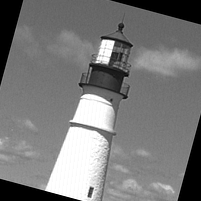

In [392]:
H,W = size(red)
resampled = zeros((H,W))
for y = 1:H
    for x = 1:W
        dx = x - W/2
        dy = y - H/2
        rx = W/2 +  cos(rangle) * dx + sin(rangle) * dy
        ry = H/2   -sin(rangle) * dx + cos(rangle) * dy        
        rpixel = lanczos3_shift_2d(red, rx, ry)
        resampled[y,x] = rpixel
    end
end
Gray.(resampled)


In [402]:
function rotate_image(image, angle)
    rangle = deg2rad(angle)
    H,W = size(image)
    resampled = zeros((H,W))
    for y = 1:H
        for x = 1:W
            dx = x - W/2
            dy = y - H/2
            rx = W/2 +  cos(rangle) * dx + sin(rangle) * dy
            ry = H/2   -sin(rangle) * dx + cos(rangle) * dy        
            rpixel = lanczos3_shift_2d(image, rx, ry)
            resampled[y,x] = rpixel
        end
    end
    resampled
end

rotate_image (generic function with 1 method)

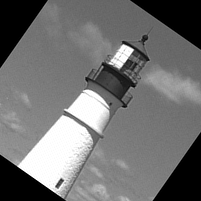

In [403]:
angle = 35.
oneshot = rotate_image(red, angle)
Gray.(oneshot)

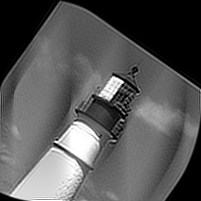

In [404]:
working_image = red
for i = 1:35
    result = rotate_image(working_image, 1)
    working_image = result
    #working_image = rotate_image(working_image, 1)
end
Gray.(working_image)


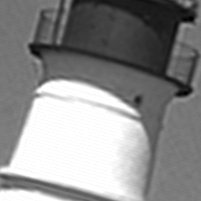

In [396]:
H,W = size(red)
resampled = zeros((H,W))
for y = 1:H
    for x = 1:W
        dx = x - W/2
        dy = y - H/2
        rx = W/2 + 0.3 * ( cos(rangle) * dx + sin(rangle) * dy)
        ry = H/2 + 0.3 * (-sin(rangle) * dx + cos(rangle) * dy)       
        rpixel = lanczos3_shift_2d(red, rx, ry)
        resampled[y,x] = rpixel
    end
end
Gray.(resampled)


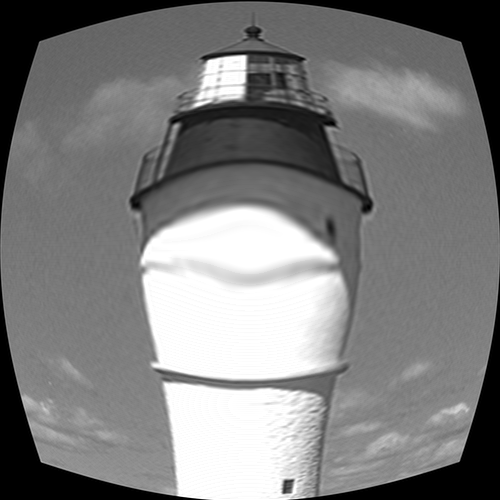

In [398]:
rH,rW = 500,500
resampled = zeros((rH,rW))
for y = 1:rH
    for x = 1:rW
        fx = 2. * (x/rW - 0.5)
        fy = 2. * (y/rH - 0.5)
        r = max(hypot(fx, fy), 0.001)
        
        rx = (r^2 * (fx/r) / 2 + 0.5) * W
        ry = (r^2 * (fy/r) / 2 + 0.5) * H

        rpixel = lanczos3_shift_2d(red, rx, ry)
        resampled[y,x] = rpixel
    end
end
Gray.(resampled)

In [399]:
using FITSIO
using WCS